## Agente con todas las caracteristicas anteriores y persistencia de conversaciones

### Aparte de este codigo necesitas tambien tener: 
1. la base de datos que dice leyes recursive.db
2. El archivo de categorias_sinonimos_bolivia.json
3. y si es necesario el codigo para segmentar y indexear los archivos

In [20]:
# Base de datos de vectores

from pathlib import Path
from dotenv import load_dotenv

import os

load_dotenv()


base_dir = Path.cwd()
leyes_dir = base_dir / "leyes"  

# If leyes_dir doesn't exist, try going up one level
if not leyes_dir.exists():
    leyes_dir = base_dir.parent / "leyes"

Definir Embeddings y LLM

In [21]:
from langchain_openai import ChatOpenAI
from langchain_openai.embeddings import OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002",
)

openai_api_key = os.getenv("DEEPSEEK_API_KEY")
openai_base_url = os.getenv("DEEPSEEK_API_URL")
openai_model = os.getenv("LLM_MODEL")

# Crear una instancia del modelo ChatOpenAI
llm = ChatOpenAI(
    # base_url=openai_base_url,
    # api_key=openai_api_key,
    model= openai_model,
    temperature=0.5, 
    
)
print(llm)

client=<openai.resources.chat.completions.completions.Completions object at 0x00000233F98CE2D0> async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000233F98CE210> root_client=<openai.OpenAI object at 0x00000233E347EE90> root_async_client=<openai.AsyncOpenAI object at 0x00000233E347F610> model_name='gpt-4o-mini' temperature=0.5 model_kwargs={} openai_api_key=SecretStr('**********')


Herramienta Recuperadora de Docs

In [22]:
from langchain_community.vectorstores import SQLiteVec
from langchain_core.tools import tool

numero_docs_recuperados: int  = 4

@tool(response_format="content_and_artifact")
def recuperarDocs(query: str):
    """Retrieve information related to a query."""
    try:
        db_path_str = str(base_dir / "Database/leyes OpenAI.db")

        vector_store = SQLiteVec(
        table="leyes",
        connection=None,
        embedding=embeddings,
        db_file=db_path_str,
        )   
        
        retrieved_docs = vector_store.similarity_search(query, k=numero_docs_recuperados)
        
        # Properly access document attributes
        serialized = "\n\n".join(
            (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}" )
            for doc in retrieved_docs
        )
        return serialized, retrieved_docs
    except Exception as e:
        # Add error logging for debugging
        print(f"Error in recuperarDocs: {e}")
        print(f"Type of error: {type(e)}")
        import traceback
        traceback.print_exc()
        # Return a fallback response
        return "Error retrieving documents", []
tools = [recuperarDocs]

Definimos el estado que será pasado entre objetos para guardar mensajes


In [23]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]
    summary: str
    rewrite_count: int = 0

Definimos Edges (aristas) entre los nodos

In [24]:
from typing import  Literal
from langchain_core.messages import  HumanMessage, RemoveMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langchain import hub

### Edges
rewrite_limit = 1
max_messages_before_summarize = 5

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")
    
    rewrite_count = state.get("rewrite_count", 0)
    if  rewrite_count >= rewrite_limit:
        print(f"---LÍMITE DE REFORMULACIONES ALCANZADO ({rewrite_count}/{rewrite_limit})---")
        return "generate"

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model=openai_model, streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""Eres un evaluador que determina la relevancia de un documento recuperado para una pregunta del usuario. \n 
        Aquí está el documento recuperado: \n {context} \n
        Aquí está la pregunta del usuario: {question} \n
        Si el documento contiene informacion para responder la pregunta de manera explicita calificar como relevante \n
        Da una puntuación binaria 'yes' o 'no' para indicar si el documento es relevante para la pregunta.""",
        input_variables=["context", "question"],
        )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score
    

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print(f"---DECISION: DOCS NO RELEVANTES (Intento {rewrite_count+1}/{rewrite_limit})---")
        print(score)
        return "rewrite"
    

def summarize_or_prewrite(state) -> Literal["summarize_conversation", "pre_rewrite"]:
    messages = state["messages"]
    
    if len(messages) >= max_messages_before_summarize:
        print(f"---LIMITE DE MENSAJES ALCANZADO ({len(messages)}/{max_messages_before_summarize})---")
        return "summarize_conversation"
    
    return "pre_rewrite"


Definimos los Nodos

In [ ]:
### Nodes
import json
from pathlib import Path
import re

def summarize_conversation(state):
    """
    Summarize the conversation so far to provide context for the agent.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the summary appended to messages
    """
    print("---SUMMARIZE---")
    
     # First, we get any existing summary
    summary = state.get("summary", "")
    if summary:
        # A summary already exists
        summary_message = (
            f"Este es el resumen de la conversacion hasta ahora: \n{summary}\n"
            "Extiende el resumen tomando en cuenta los mensajes anteriores:"
        )
    else:
        summary_message = "Crea un resumen corto de la conversacion en previa:"
    
    
    messages = state["messages"] + [SystemMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-1]]
    return {"summary": response.content, "messages": delete_messages}

def pre_rewrite(state):
    """
    Pre-processing step to transform the query before retrieval.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """
    print("---PRE-REWRITE---")
    
    reset_rewrite_count = 0
    state["rewrite_count"] = reset_rewrite_count
    
    messages = state["messages"]
    question = messages[0].content

    # Load the synonyms from the JSON file
    with open(Path.cwd() / "categorias_sinonimos_bolivia.json", "r", encoding="utf-8") as f:
        synonyms = json.load(f)
    print(synonyms)

    # Create a mapping of colloquial terms to standardized terms
    colloquial_to_standard = {}
    for category, terms in synonyms.items():
        standard_term = category.split(" / ")[0].lower()  # Use the category name as the standard term
        for term in terms:
            colloquial_to_standard[term.lower()] = standard_term

    # Replace colloquialisms in the question

    words = re.findall(r'\b\w+\b', question)
    standardized_words = [
        colloquial_to_standard.get(word.lower(), word) for word in words
    ]
    standardized_question = " ".join(standardized_words)

    print(f"Original question: {question}")
    print(f"Standardized question: {standardized_question}")

    # Update the state with the standardized question
    return {"messages": [HumanMessage(content=standardized_question)]}



def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    last_message = messages[-1]

    summary = state.get("summary", "")

    if summary:
        sys_msg=f"""
            Eres un asistente legal que responde preguntas sobre el reglamento de tránsito boliviano.\n
            Aquí está el resumen de la conversación hasta ahora:\n
            {summary}\n
            si necesitas usa la herramienta de recuperacion de informacion, haz el query breve y no menciones a bolivia.
        """
    else:
        sys_msg="""
            Eres un asistente legal que responde preguntas sobre el reglamento de tránsito boliviano.\n
            Si necesitas usa la herramienta de recuperacion de informacion, haz el query breve y no menciones a bolivia.
        """
        
    # System message
    system_message = SystemMessage(content=sys_msg)
    model = ChatOpenAI(temperature=0, streaming=True, model=openai_model)
    model = model.bind_tools(tools)
    
    response = model.invoke([system_message, last_message])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        SystemMessage(content=f""" \n 
        Observa la entrada e intenta razonar sobre la intención / significado semántico subyacente. \n 
        Aquí está la pregunta inicial:
        \n ------- \n
        {question} 
        \n ------- \n
        Formula una breve pregunta mejorada: """,
            )
        ]

    # Increment the rewrite counter
    new_count = state.get("rewrite_count", 0) + 1
    
    # Grader
    model = ChatOpenAI(temperature=0, model=openai_model, streaming=True)
    response = model.invoke(msg)
    return {"messages": [response], "rewrite_count": new_count}


def generate(state):
    """
    Generate answer
    Args:
        state (messages): The current state
    Returns:
         dict: The updated state with re-phrased question
    """
    
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[1].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    template = """ Responde exclusivamente en español. 
    Eres un asistente legal que puede responder preguntas sobre el reglamento de tránsito boliviano.
    Usa solamente información de la referencia para responder. 
    En caso de que no encuentres la respuesta en la referencia, responde con "No tengo información sobre eso".
    En tu respuesta menciona el articulo que corresponda a tu respuesta y el document_title.

    Usa la siguiente información como referencia: 
    {context}

    Responde a la siguiente pregunta:
    {question}

    Respuesta:"""
    custom_rag_prompt = PromptTemplate.from_template(template)

    # LLM
    llm = ChatOpenAI(model_name=openai_model, temperature=0, streaming=True)
    
    # Chain
    rag_chain = custom_rag_prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

Declaracion de Base de datos de Checkpoints

In [26]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = base_dir / "Database/checkpoints.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
memory = SqliteSaver(conn)

Compilado del grafo

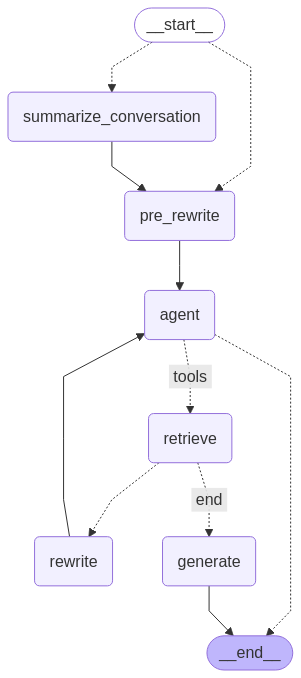

In [27]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("summarize_conversation", summarize_conversation)  
workflow.add_node("pre_rewrite", pre_rewrite)  
workflow.add_node("agent", agent)  
retrieve = ToolNode([recuperarDocs])
workflow.add_node("retrieve", retrieve)  
workflow.add_node("rewrite", rewrite) 
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_conditional_edges(
    START, 
    summarize_or_prewrite,
    {
        "summarize_conversation": "summarize_conversation",
        "pre_rewrite": "pre_rewrite"
    }
)

workflow.add_edge("summarize_conversation", "pre_rewrite")
workflow.add_edge("pre_rewrite", "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate": "generate",
        "rewrite": "rewrite",
        "end": "generate"  # If we hit the limit, go to generate anyway
    }
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Generamos id al hilo y procedemos a preguntar

In [28]:
from langchain_core.messages import  HumanMessage
from langgraph.config import RunnableConfig
import uuid

thread_id = str(uuid.uuid4())
print(f"----NUEVA CONVERSACION CREADA CON ID: {thread_id} ----")

config: RunnableConfig = {"configurable": {"thread_id": thread_id}}

messages = [
    HumanMessage(content="¿Que pasa si un paco me para por tener vidrios oscuros"),
]
output_messages = graph.invoke({"messages": messages}, config)
last_message = output_messages['messages'][-1]
last_message.pretty_print()
    
    
# Comenzar conversacion
messages = [
    HumanMessage(content="¿tiene alguna multa?"),
]
output_messages = graph.invoke({"messages": messages}, config)
last_message = output_messages['messages'][-1]
last_message.pretty_print()

----NUEVA CONVERSACION CREADA CON ID: bf718c41-444e-4cd1-a0aa-63ac4b589ac7 ----
---PRE-REWRITE---
{'Policía / Tránsito': ['paco', 'policia', 'tránsito', 'oficial', 'agente de tránsito', 'operativo', 'patrullero', 'control', 'control de tránsito', 'control vehicular', 'control de vehículos', 'control de tránsito vehicular', 'control de tránsito automotor', 'control de tránsito terrestre'], 'Licencias': ['licencia', 'brevete', 'breve', 'brevet', 'permiso de conducir', 'carnet de conducir', 'licencia de conducir', 'duplicado', 'categoría a', 'categoría b', 'categoría c', 'categoria T', 'categoria P', 'categoria P (particular)', 'profesional A', 'profesional B', 'profesional C', 'profesional C indefinida', 'profesional T', 'licencia categoria A', 'licencia categoria B', 'licencia categoria C', 'licencia categoria T', 'licencia categoria P', 'licencia categoria P (particular)', 'licencia profesional A', 'licencia profesional B', 'licencia profesional C', 'licencia profesional C indefinida',